# Using Machine Learning to Predict Stock Prices

## Authors: Yijia Song, Daniel Korn, Nicole Davis, Yidi Wang
## Group 52
### 4/17/2023

In [1]:
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import pandas as pd
from pandas_datareader import DataReader
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score


In [2]:
# https://medium.com/wealthy-bytes/5-lines-of-python-to-automate-getting-the-s-p-500-95a632e5e567
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
temp_df = table[0]

In [3]:
# this is a list of all the stocks in the s&p 500
sp = list(temp_df['Symbol'])

In [4]:
#SPY is an ETF to track the S&P500 performance (which is all US based stock exchanges not just NYSE)
sp.append('SPY')

# list of common ETF for different industries
etf = ['XLB','XLU', 'XLE','XLF','XLI','XLK','XLP', 'XLV', 'XLY', 'XLC', 'XLRE']

# adding the ETF values into the s&p list so people can also see how an industry is doing
for vals in etf:
    sp.append(vals)
    
# removing the tickers that are not on yahoo finance and have likely been delisted
sp.remove('BRK.B')
sp.remove('BF.B')

In [5]:
# last 5 years of data downloaded
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# this i found online and it makes all of the stocks have there own dataframe
# I did it this way because otherwise the formating of one large dataframe was messy and hard to work with
#https://github.com/sajal2692/data-science-portfolio/blob/master/Stock%20Market%20Analysis%20for%20Tech%20Stocks.ipynb
for stock in sp:
    globals()[stock] = yf.download(stock, start, end)
  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
# this is a user input so a user can look into any stock they are interested in 
ticker = input('Please enter the stock ticker you would like to predict the price of ')
tick = eval(ticker)

Please enter the stock ticker you would like to predict the price of MSFT


In this section it just focuses on scaping the data from the internet so that we can use it. Some of us hav taken a Finance + Python class that uses the yf module a lot so I was familiar with how to do it. We chose to download every stock as its own data frame because the formatting of one big data frame was stacked and hard to deal with. This also helps everything run faster because the data frames are more specified.

## EDA

In [7]:
tick.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-04-17 to 2023-04-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


All of the types look correct for the data they are holding.

For people unfamiliar with stocks the Open is the price the stock is when the market it trades on opens, the high is the highest price it trades at that day, the low is the lowest price it trades at that day, the close is the price the stock is when the market closes, the adj close is the adjusted close price of the stock once you take into account dividends and the volume is the number of shares of the stock that traded during that spefific time period.

In [8]:
tick.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no null values in any of the colunmns or rows.

In [9]:
tick.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,203.349030,205.506216,201.096621,203.414706,199.486206,3.013051e+07
std,71.666322,72.427673,70.864856,71.686610,72.533535,1.281438e+07
min,92.959999,93.300003,90.279999,92.309998,87.119820,8.989200e+06
25%,136.277500,136.897499,134.782501,135.994995,131.299191,2.216015e+07
50%,213.654999,215.445000,211.220001,213.479996,208.820175,2.704610e+07
75%,259.849991,263.025009,257.082504,260.572487,257.702545,3.405380e+07
max,344.619995,349.670013,342.200012,343.109985,339.075531,1.112421e+08


Here are the summary statistics for the ticker the user picks, we are not going to go through all of it but you can see the 5 years of data has 1259 entries and the MSFT stock price high is 349.67 across those years, the low is 90.27 which is a very wide range. The volume of stock traded varied from 4,088,796 to 111,242,100. And the mean stock price for open, high, low, close and adj close is all between 199 and 205 dollars.


In general there is not a lot of data cleaning to do in this section because we scraped the data from yahoo finance which is fairly comprehensive.

## Data Investigation

In [10]:
tick.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-17,95.000000,96.540001,94.879997,96.070000,90.668419,26771000
2018-04-18,96.220001,96.720001,95.519997,96.440002,91.017647,21043300
2018-04-19,96.440002,97.070000,95.339996,96.110001,90.706177,23552500
2018-04-20,95.910004,96.110001,94.050003,95.000000,89.658607,31154400
2018-04-23,95.739998,96.290001,94.629997,95.349998,89.988914,22331800


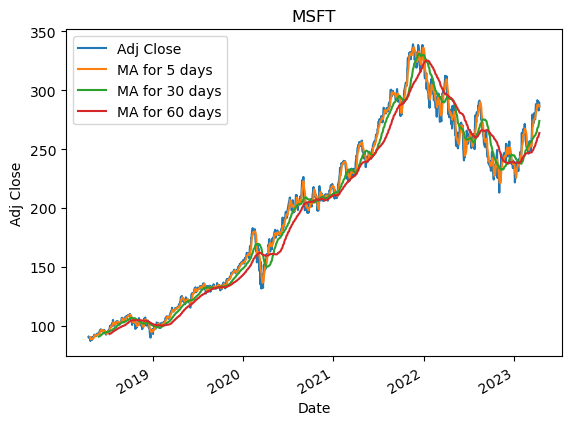

In [11]:
# calculates the moving average and adds it to the dataframe
# I got this code from here: https://github.com/sajal2692/data-science-portfolio/blob/master/Stock%20Market%20Analysis%20for%20Tech%20Stocks.ipynb
ma_lst = [5,30,60]

# adds the MA to the dataframe
for ma in ma_lst:
    column_name = "MA for %s days" %(str(ma))
    
    tick[column_name] = tick['Adj Close'].rolling(window=ma).mean()

tick[['Adj Close','MA for 5 days','MA for 30 days','MA for 60 days']].plot()
plt.title(ticker)
plt.ylabel('Adj Close')
plt.show()

This graph helps demonstrate the change in the adjusted close stock price over the last five years. It also looks at the moving averages for some different time spans (5,30 and 60 days). Analysts often using moving averages to see where a stock is trending and make predictions. This could be helpful to look at when trying to think more long term about what a stock is going to do. This graph shows us that the adjusted close price of the MSFT stock has mostly been increasing over the last five years which some occassional dips.

In [12]:
#The daily return column can be created by using the percentage change over the adjusted closing price
tick['Daily Return'] = tick['Adj Close'].pct_change()

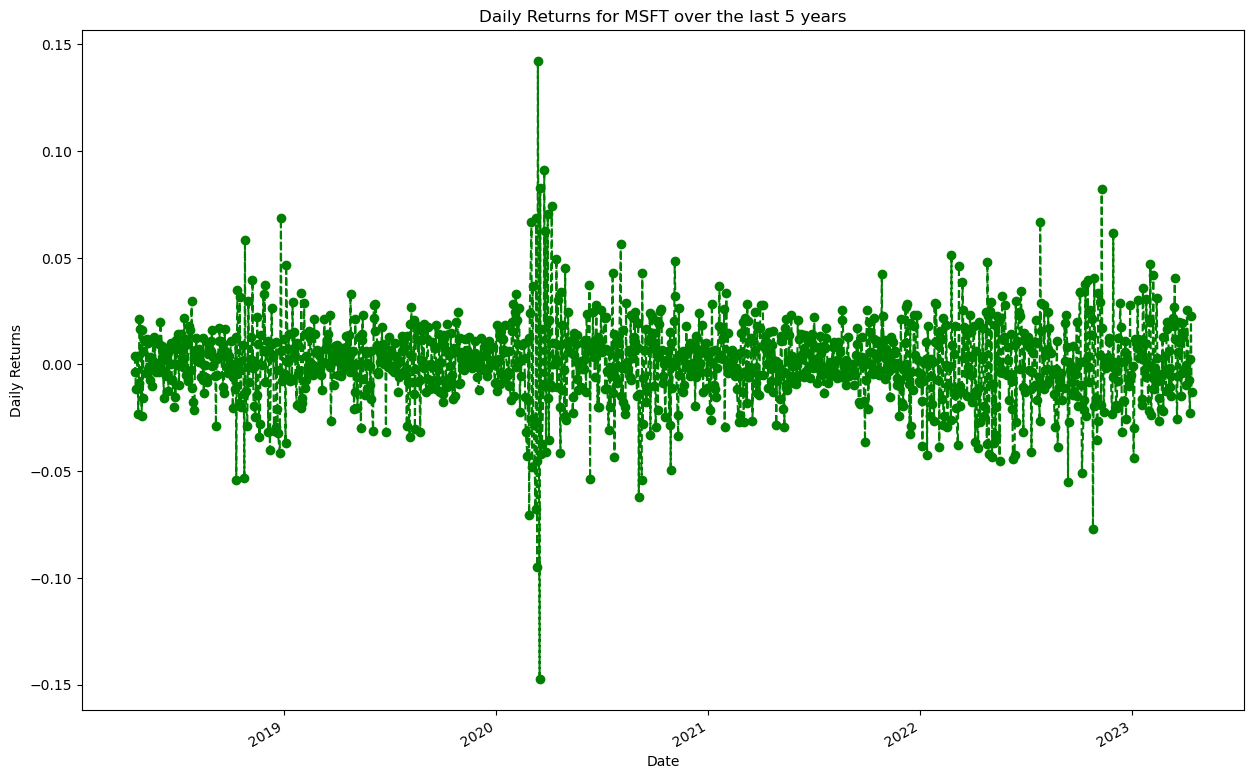

In [13]:
# Then we'll plot the daily return percentage, this was also inspired by the same github proj above
# it helps the user see how much the daily returns of stocks fluctuate and how volatile the stock market is
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(15)


tick['Daily Return'].plot(linestyle='--', marker='o', color = 'green')

title = 'Daily Returns for ' + ticker + ' over the last 5 years'

plt.title(title)
plt.ylabel('Daily Returns')
plt.xlabel('Date')
plt.show()

We created this graph to show the volatility of the stock market and how greatly the returns of a stock can change. This is to further demonstrate the point that it is very difficult to predict what a stock is going to do.

In [14]:

df = yf.download(etf, start, end)['Adj Close']

[*********************100%***********************]  11 of 11 completed


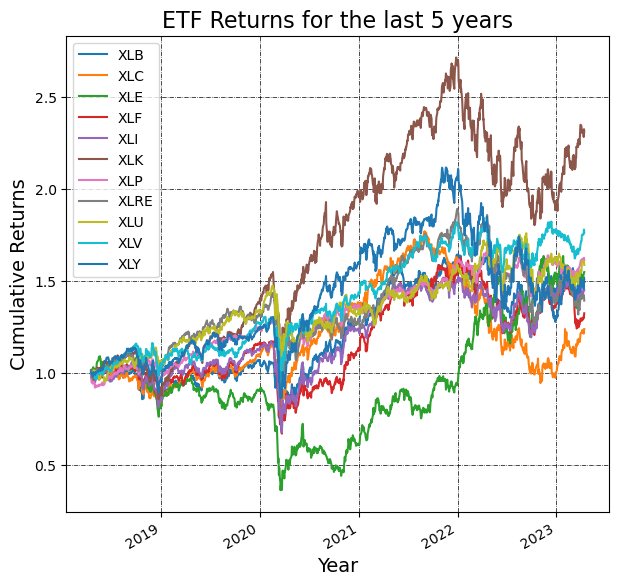

In [15]:
# Plot all the close prices
((df.pct_change()+1).cumprod()).plot(figsize=(7, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("ETF Returns for the last 5 years", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

This graph helps demonstrate the overall health of the market across the timespan we are analyzing. It looks at 11 ETF's which are Exchange-Traded Funds which invest in certain sectors like Technology, Health Care and Energy. We can see for the most part the market is healthy and the ETF's are generating increasing positive returns. 


## Random Forest Regression Algorithm: Our Chosen one

In [16]:
tick.head()

,Open,High,Low,Close,Adj Close,Volume,MA for 5 days,MA for 30 days,MA for 60 days,Daily Return
Date,,,,,,,,,,
2018-04-17,95.000000,96.540001,94.879997,96.070000,90.668419,26771000,NaN,NaN,NaN,NaN
2018-04-18,96.220001,96.720001,95.519997,96.440002,91.017647,21043300,NaN,NaN,NaN,0.003852
2018-04-19,96.440002,97.070000,95.339996,96.110001,90.706177,23552500,NaN,NaN,NaN,-0.003422
2018-04-20,95.910004,96.110001,94.050003,95.000000,89.658607,31154400,NaN,NaN,NaN,-0.011549
2018-04-23,95.739998,96.290001,94.629997,95.349998,89.988914,22331800,90.407953,NaN,NaN,0.003684


In [17]:
# splitting up the data into test and train sets
x = tick[['Open', 'High','Low', 'Volume']]
y = tick['Adj Close']

# testing and training the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)

Because the data is continous and includes time (time dependent) we dont want to shuffle or include a random_state in our training and test sets. This is different than we've done in class but we also include smaller test_sizes so there are more testing and training groups. This is the same test and train data sets you will see for all 3 models.

In [18]:
from sklearn.model_selection import GridSearchCV

# define the grid search parameters
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# create a decision tree regressor object
regression = RandomForestRegressor()

# instantiate the grid search model
grid_search = GridSearchCV(estimator=regression, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# fit the grid search model to the data
grid_search.fit(x_train, y_train)

# print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters:  {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  -1.259646595993653


In [19]:
# use the best parameters to create a new regression model
regression = RandomForestRegressor(**grid_search.best_params_)
regression.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, max_features=None)

In [20]:
# making predictions
pred=regression.predict(x_test)

In [21]:
# compares the actual price and what the algorithm predicted
dfr=pd.DataFrame({'actual_price':y_test, 'predicted_price':pred})
dfr.head()

,actual_price,predicted_price
Date,,
2022-07-15,254.818069,256.547695
2022-07-18,252.366379,254.093676
2022-07-19,257.607269,255.176158
2022-07-20,260.326965,257.979542
2022-07-21,262.877899,258.217861


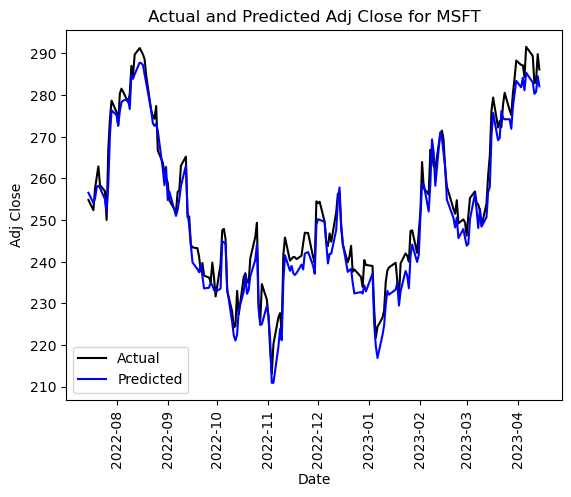

In [22]:
# plotting the two lines
plt.plot(dfr.actual_price, color='black', label = 'Actual')
plt.plot(dfr.predicted_price, color='blue', label = 'Predicted')

# ading labels and titles 
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation = 90)

title = 'Actual and Predicted Adj Close for ' + ticker
plt.title(title)

plt.legend()
plt.show()



In [23]:
mse = mean_squared_error(y_test, pred)
mse

15.312210484766009

In [24]:
reg_conf = regression.score(x_test, y_test)
print("regression confidence: ", reg_conf)

regression confidence:  0.9563473784590941


Here we can see that the regression confidence is almost 96% this can be interpreted that there is a 96% probability that regression line of the population will fall within the confidence interval of the regression line created from the sample data.

To compare our models we chose to use MSE which is the average of the squares of the errors of all the data.

The MSE for this model is not too bad at 15.24 because we are working with large numbers like 200-300. This MSE means that that the average difference between the actual adj close price and our models predicted adj close price is $15. In a perfect world our MSE would be lower but this is not a bad start considering how volatile the stock market is.

Given these numbers this is a potential choice for our final model.

In [25]:
# this function is copied from ds2500 
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Decision Trees)')
    plt.title('Feature Importance Graph')

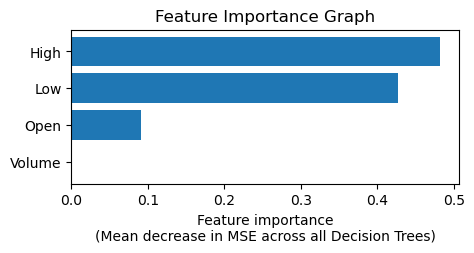

In [26]:
x_feat_list = ['Open', 'High', 'Low', 'Volume']
# plotting the importance of each feature
plot_feat_import(x_feat_list, regression.feature_importances_)

This feature importance graph shows that the High stock price impacts the adjusted close of the stock the most, it can account for almost 55% of the mean decrease in MSE. Then Low price with about 40% and then Open with much less of an impact, only about 5%. Volume does not impact the adjusted close price very much/at all.


# KNN Regression

In [27]:
# setting up x and y variables
X = tick[['Open', 'High','Low', 'Volume']]
y = tick['Adj Close']


In [28]:
# training and testing the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15 , shuffle=False,random_state = 0)

In [29]:
# initializing model
knn = KNeighborsRegressor() 

# hypertuning
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# finding the best parameters
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

grid_search = GridSearchCV(knn, param_grid=grid)
grid_result = grid_search.fit(X_train, y_train)


# print the best parameters 
print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}


In [30]:
# making the model with the best parameters
knn = KNeighborsRegressor(**grid_search.best_params_) 

# fitting with data segments
knn.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=7)

In [31]:
# compares the actual price and what the algorithm predicted
y_pred   = knn.predict(X_test)


dfr_knn=pd.DataFrame({'actual_price':y_test, 'predicted_price':y_pred})
dfr_knn.head()

,actual_price,predicted_price
Date,,
2022-07-15,254.818069,167.781905
2022-07-18,252.366379,247.548319
2022-07-19,257.607269,198.347975
2022-07-20,260.326965,167.412522
2022-07-21,262.877899,227.513550


In [32]:
# this gets the dates so we can use it as the Y-axis later on for the SVR graph
dfr_knn = dfr_knn.reset_index()

dates = dfr_knn['Date']


dfr_knn = dfr_knn.set_index('Date')

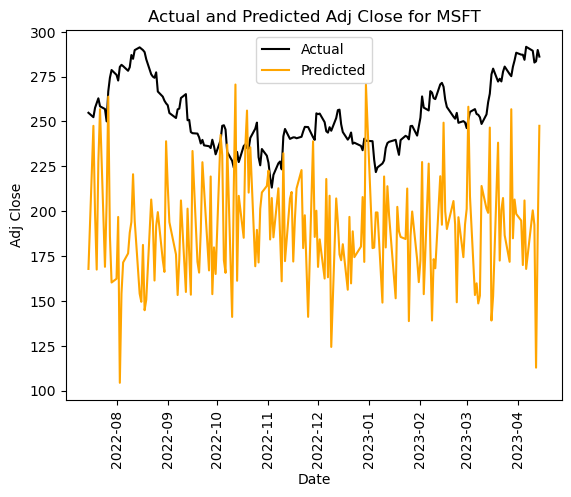

In [33]:
# plotting actual vs. predicted
plt.plot(dfr_knn.actual_price, color='black', label = 'Actual')
plt.plot(dfr_knn.predicted_price, color='orange', label = 'Predicted')

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation = 90)

title = 'Actual and Predicted Adj Close for ' + ticker
plt.title(title)


plt.legend()
plt.show()


In [34]:
mse = mean_squared_error(y_test, y_pred)
mse

5421.578688555342

The MSE is really bad at 5460.95 This MSE means that that the average difference between the actual adj close price and our models predicted adj close price is 5460 dollars. This is likely because our predictions fluctuate up and down so much in a short amount of time for this model, that our predicts end up being very far away from the actual price.

Given that MSE this is not a model we would consider using for these purposes.


## SVR

In [35]:
# getting x and y variables
X = tick[['Open', 'High', 'Low', 'Volume']]
y = tick[['Adj Close']]

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15 , shuffle=False,random_state = 0)

In [36]:
# getting copies of the sets
X_train = X_train.copy()
X_test  = X_test.copy()

In [37]:
#normalize the numeric features 
# y needs to be normalized too 
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

 

In [38]:
# hypertuning C and gamma, kernel is set because it uses too much memory to test for all 3
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
# finding the best parameters and fitting them to the model
grid = GridSearchCV(SVR(), param_grid, refit = True)
grid.fit(X_train,y_train.ravel())

print(grid.best_estimator_)
print(grid.best_params_)

SVR(C=1000, gamma=0.001)
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [39]:
# use the best parameters to create a new model
svr = SVR(**grid.best_params_)
svr.fit(X_train, y_train.ravel())

SVR(C=1000, gamma=0.001)

In [40]:
#predict the labels for the test set
y_pred   = svr.predict(X_test)


In [41]:
# this is turning the data back to the adjusted stock price and reversing the scale we used to train
# so we can actual compare the model

new_y_test = scalery.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

new_y_pred = scalery.inverse_transform(y_pred.reshape(-1,1)).reshape(-1)


In [42]:
# for some reason there was an issue with the dates as the index so I overwrote the index and added it 
# compares the actual and predicted price
dfr_svm=pd.DataFrame({'actual_price':new_y_test, 'predicted_price':new_y_pred})
dfr_svm = dfr_svm.set_index(dates)
dfr_svm.head()

,actual_price,predicted_price
Date,,
2022-07-15,254.818069,253.574915
2022-07-18,252.366379,252.555180
2022-07-19,257.607269,252.391888
2022-07-20,260.326965,257.399458
2022-07-21,262.877899,256.582705


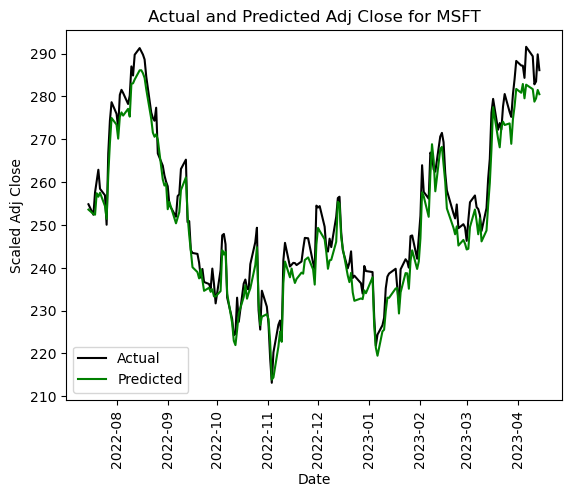

In [43]:
# plotting actual vs. predicted price
plt.plot(dfr_svm.actual_price, color='black', label = 'Actual')
plt.plot(dfr_svm.predicted_price, color='green', label = 'Predicted')
plt.plot()

# adding labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Adj Close')
plt.xticks(rotation = 90)

title = 'Actual and Predicted Adj Close for ' + ticker 
plt.title(title)

plt.legend()

plt.show()


In [44]:
mse = mean_squared_error(y_test, y_pred)
mse

0.0031226083537175754

The MSE for this model is very good at 0.0031. This MSE means that that the average difference between the actual adj close price and our models predicted adj close price is 0.003 dollars. There is not much room for improvement when it comes to this MSE and it is a contender for our final model.

## Conculsion


As our final model we chose to use the Random Forest Regression.

This model has a high regression confidence with 96%, and it is good at handling large datasets since our dataset contains 5 years of data for one stock. Next, Stock price data often exhibits non-linear relationships between predictor variables and 'Adj Close', and Random Forest Regressor is a good choice for handling non-linear relationships. Finally, overfitting could be a common problem in machine learning where a model performs well on training data but poorly on test data. Random Forest Regressor is designed to be robust to overfitting and can perform well on unseen data. 

While the MSE of the SVR model is less the MSE of the RFR is still fairly good and because of the above reasons we believe it is the better choice for this project.